# This is a simple notebook that explores what happens to one realization when rules are applied

In [1]:
import os
import glob
import numpy as np
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import itertools

In [2]:
# directory where the experiment data is stored
experiment_data_dir = './xdd_parquet_new'
flow_data_dir = './xdd_parquet_flow'

Read in realization drought counts

In [3]:
droughts_df=pd.read_csv('drought_counts_all_realizations.csv', index_col=0)

Function converting order number to sample and realization for file retrieval

In [4]:
no_to_realization = lambda x: (int(x/10)+1, (x)%10+1)

Identify realizations similar to history (drought years=22)

In [5]:
np.where(droughts_df['Total counts'] == 22)[0]

array([  4,  30, 177, 430, 895, 904])

In [6]:
realization_number = 4
sample, realization = no_to_realization(realization_number)
print(sample, realization)

1 5


Create glob path to specific realization results

In [7]:
# target glob path
glob_path = os.path.join(experiment_data_dir, f'**/S{sample}_{realization}_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 477540  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))

Exploring 286,046,460 records over 599 files.


Identify all records for specific gauge

In [52]:
structures = ('09163500', '09085100', '09050700', '09019500', 
                    '3600687', '7000550', '7200799', '7200645')
sql = f"""
SELECT *
FROM
    '{glob_path}' 
WHERE
    structure_id in {structures};
"""
#09163500, 09085100, 09050700, 09019500
# get query result as a data frame
df = duckdb.query(sql).df()

In [53]:
#sort dataframe by demand rule
df = df.sort_values(by=['sample', 'realization', 'demand rule', 'structure_id'])

Read flow-only experiment results for the same realization

In [54]:
flow_only_path = os.path.join(flow_data_dir, f'S{sample}_{realization}.parquet')

sql = f"""
SELECT *
FROM
    '{flow_only_path}' 
WHERE
    structure_id in {structures};
"""
#09163500, 09085100, 09050700, 09019500
# get query result as a data frame
df_flow = duckdb.query(sql).df()


In [55]:
df_flow = df_flow.sort_values(by=['sample', 'realization', 'structure_id'])

List of gauges

In [10]:
gauges = ['09163500', '09085100', '09050700', '09019500']

# Streamflow comparison plot
First look at what happens at an annual scale

In [56]:
gauge = gauges[0]

# extract changed flows for specific gauge
changed_flows = np.reshape(df[df['structure_id']==gauge]['river_outflow'].values, 
                           (int(len(df)/len(structures)/n_files), n_files), order='F')

original_flows = df_flow[df_flow['structure_id']==gauge]['river_outflow'].values

differences = changed_flows - original_flows[:,None]
negatives = differences < 0
# dif_to_add = negatives*1000000

#changed_flows = changed_flows + dif_to_add

changed_flows_annual = np.zeros((int(len(df)/len(structures)/n_files/12), n_files))
for j in range(n_files):
    changed_flows_annual[:,j] = np.add.reduceat(changed_flows[:,j], np.arange(0, len(changed_flows[:,j]), 12))
changed_flows_annual = np.around(changed_flows_annual, decimals=0, out=None)*1233.4818/1000000 #convert to metric


original_flows_annual = np.add.reduceat(original_flows, np.arange(0, len(original_flows), 12))
original_flows_annual = np.around(original_flows_annual, decimals=0, out=None)*1233.4818/1000000 #convert to metric


Identify drought ranges to hightlight

In [69]:
changed_flows[:,0]-original_flows

array([      0,       0,       0,       0,       0,       0,       0,
             0, 1000000,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0, 1000000, 1000000,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0, 1000000, 1000000,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
       1000000,       0,       0,       0,     271,      17,      26,
            27,      24,      42,     304,    1771,    2826,    2645,
          1798,     359,    1528,      89,      70,      64,      27,
            18,       9,     -51,     166,      99,       0,      16,
            14,       7,       5,       4,       3,       1,       0,
            49,       9,       0,       7,       8,     179,       9,
             2,     

In [67]:
original_flows[77:87]

array([168202, 149307, 250879, 376993, 185955, 155309, 194493, 192503,
       184172, 171214])

352573022

In [22]:
droughts_df.at[realization_number,'Drought years']

'[[], [91, 92, 93, 94, 95, 96, 97, 98, 99, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 100, 101]]'

Plot realization rankings

In [13]:
sample = np.loadtxt('factorial_sample.txt') #col 0: trigger, col 1: rights, col 2: level
group = np.zeros(len(sample)).astype(int)
for s in range(len(sample)):
    #check if the % of rights is one of the low values
    if sample[s, 1] < 5:
        #check if trigger is one of the low values
        if sample[s, 0] < 3:
            #check if the curtailment level is one of the low values:
            if sample[s, 2] < 5:
                group[s]=0 # Low Low Low
            else:
                group[s]=1 # Low Low High
        else:
            #check if the curtailment level is one of the low values:
            if sample[s, 2] < 5:
                group[s]=2 # Low High Low
            else:
                group[s]=3 # Low High High
    else:
        #check if trigger is one of the low values
        if sample[s, 0] < 3:
            #check if the curtailment level is one of the low values:
            if sample[s, 2] < 5:
                group[s]=4 # High Low Low
            else:
                group[s]=5 # High Low High
        else:
            #check if the curtailment level is one of the low values:
            if sample[s, 2] < 5:
                group[s]=6 # High High Low
            else:
                group[s]=7 # High High High 


In [14]:
# Calculate rankings
from scipy.stats import rankdata
realization_rankings = np.zeros_like(changed_flows_annual)

# Loop through all timesteps and calculate relative ranks
for j in range(len(changed_flows_annual)):
    realization_rankings[j,:] = 600-rankdata(changed_flows_annual[j,:], method='min')

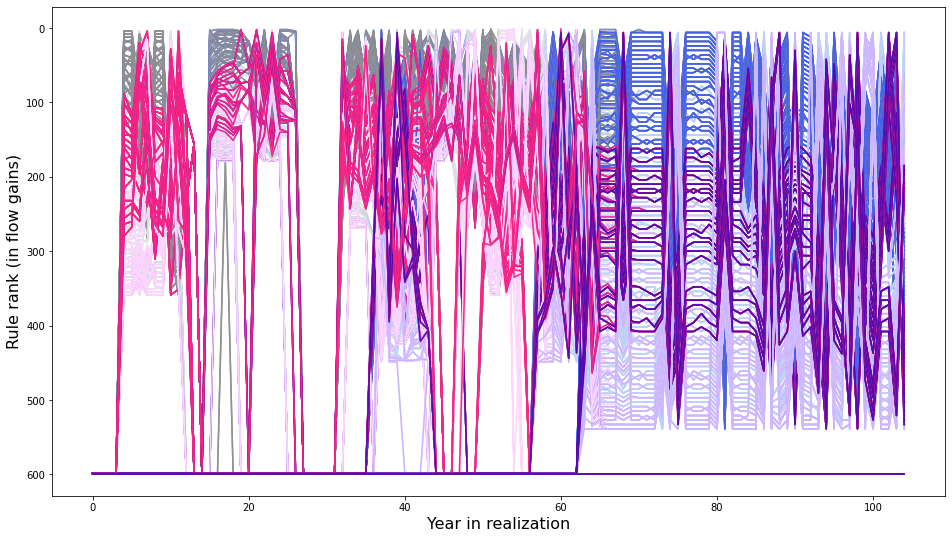

In [15]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(1,1,1)

groups_colors = ['#e2e2e2', '#ffd6ff', '#bbd0ff', '#c8b6ff', #groups 0, 1, 2, 3
                '#919191', '#f72585', '#4361ee', '#560bad'] #groups 4, 5, 6, 7

for j in range(len(changed_flows_annual[0,:])):
    ax1.plot(np.arange(105), realization_rankings[:,j], color=groups_colors[group[j]])
ax1.set_ylabel('Rule rank (in flow gains)', fontsize=16)
ax1.set_xlabel('Year in realization', fontsize=16)
ax1.invert_yaxis()

Plot specific groups of rules

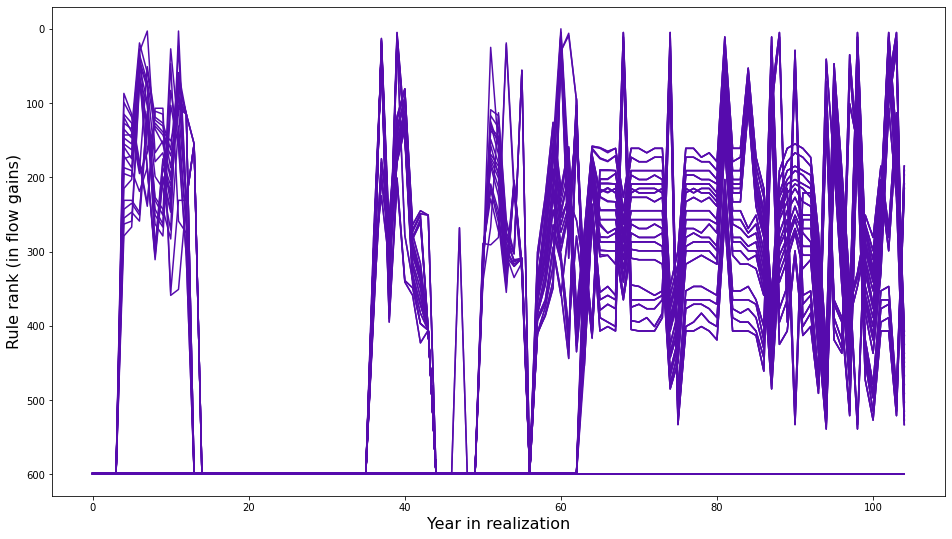

In [113]:
group_number = 7
rules_to_show = np.where(group==group_number)[0]

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(1,1,1)

for j in rules_to_show:
    ax1.plot(np.arange(105), realization_rankings[:,j], color=groups_colors[group[j]])
ax1.set_ylabel('Rule rank (in flow gains)', fontsize=16)
ax1.set_xlabel('Year in realization', fontsize=16)
ax1.invert_yaxis()

Plot only rules that reduce the original flows

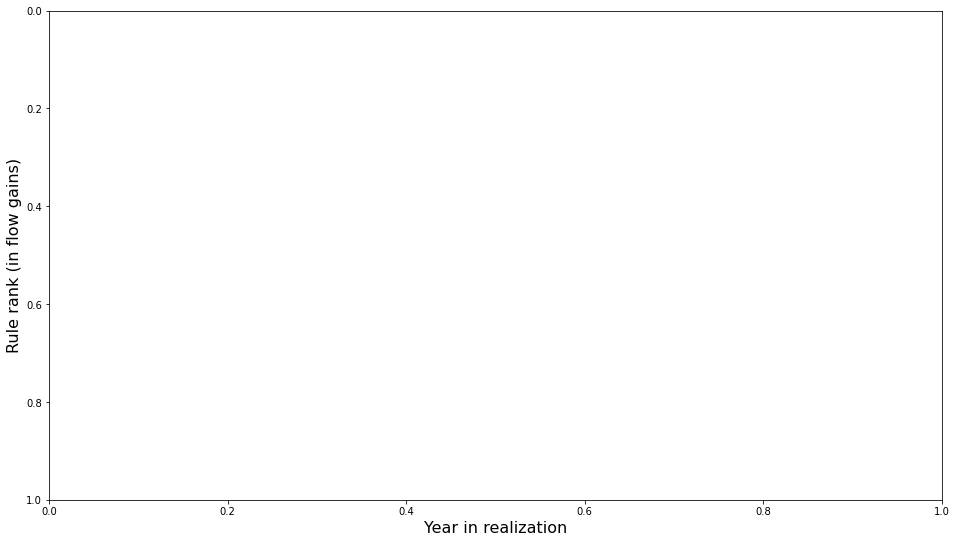

In [103]:
# rules_with_losses = []
# for j in range(len(changed_flows_annual[0,:])):
#     relative_change = (changed_flows_annual[:,j] - original_flows_annual)/original_flows_annual
#     if np.any(relative_change<-0.1): 
#         rules_with_losses.append(j)
        
# fig = plt.figure(figsize=(16,9))
# ax1 = fig.add_subplot(1,1,1)

# for j in rules_with_losses:
#     ax1.plot(np.arange(105), realization_rankings[:,j], color=groups_colors[group[j]])
# ax1.set_ylabel('Rule rank (in flow gains)', fontsize=16)
# ax1.set_xlabel('Year in realization', fontsize=16)
# ax1.invert_yaxis()

Create plot of percentile changes in flow

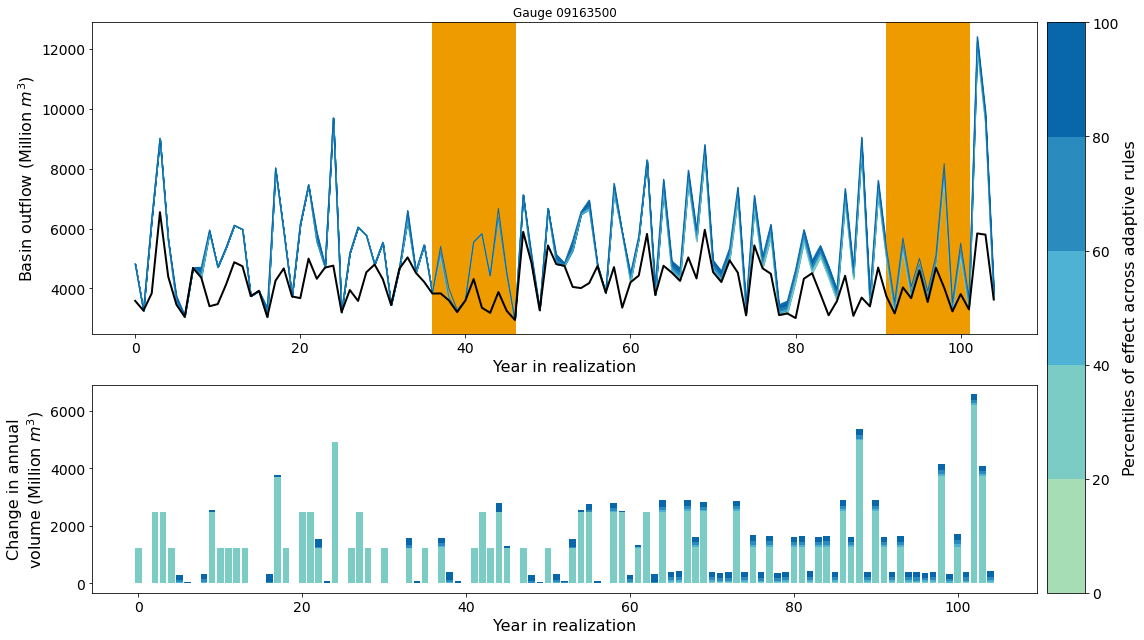

In [12]:
cmap = matplotlib.cm.get_cmap('GnBu')
p=np.arange(0, 120, 20)
num_colors=len(p)+2
colors_to_use = [cmap(1.*i/num_colors) for i in range(num_colors)][3:]

no_years = 105
fig = plt.figure(figsize=(16,9))
# parameters to specify the width and height ratios between rows and columns
widths= [25, 1]
heights = [3, 2]

gspec = fig.add_gridspec(ncols=2, nrows=2, width_ratios = widths, height_ratios = heights)
ax1 = fig.add_subplot(gspec[0,0])
ax2 = fig.add_subplot(gspec[1,0])
ax3 = fig.add_subplot(gspec[:,1])
for i in range(len(p)-1):
    ax1.fill_between(np.arange(no_years),
                     np.percentile(changed_flows_annual, p[i], axis=1), 
                     np.percentile(changed_flows_annual, p[i+1], axis=1), 
                     color=colors_to_use[i])
    ax1.plot(np.arange(no_years), 
             np.percentile(changed_flows_annual, p[i+1], axis=1), color=colors_to_use[i], linewidth=1)

    ax2.bar(np.arange(no_years), 
            np.percentile(changed_flows_annual, p[-i], axis=1) - original_flows_annual,
            color=colors_to_use[-i])
    
ax1.plot(np.arange(no_years), original_flows_annual, color='black', linewidth=2)

ax1.axvspan(36, 46, color='#EE9B00') 
ax1.axvspan(91, 101, color='#EE9B00') 

#ax1.axvspan(28, 74, color='#CA6702') 

ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('Basin outflow (Million $m^3$)', fontsize=16)
ax1.set_xlabel('Year in realization', fontsize=16)
ax1.set_title(f'Gauge {gauge}')

ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylabel('Change in annual\nvolume (Million $m^3$)', fontsize=16)
ax2.set_xlabel('Year in realization', fontsize=16)


cmap = matplotlib.colors.ListedColormap(colors_to_use)
bounds = list(p)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb2 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap,
                                norm=norm,
                                boundaries= bounds,
                                ticks=bounds,
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.tick_params(labelsize=14)
cb2.set_label('Percentiles of effect across adaptive rules', fontsize=16)

#plt.savefig(f'gauge_flow_S{sample}_{realization}.svg')
plt.tight_layout()
plt.show()

Zoom in drought periods to show monthly

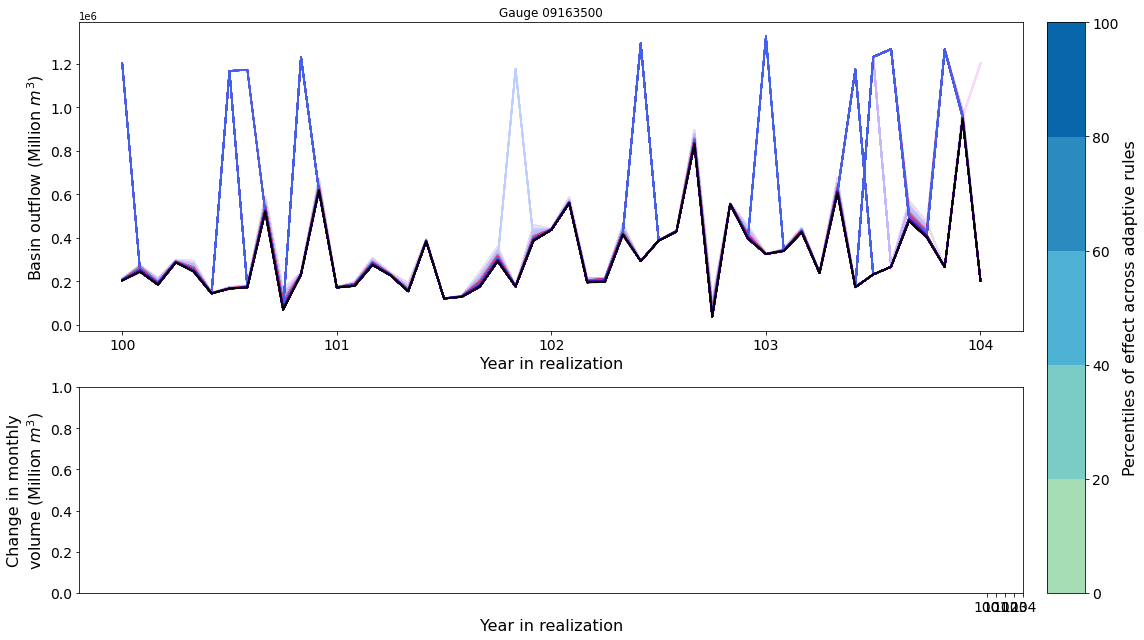

In [105]:
first_year = 100
last_year = 104
firstmonth = first_year*12
lastmonth = last_year*12+1
fig = plt.figure(figsize=(16,9))
# parameters to specify the width and height ratios between rows and columns
widths= [25, 1]
heights = [3, 2]

gspec = fig.add_gridspec(ncols=2, nrows=2, width_ratios = widths, height_ratios = heights)
ax1 = fig.add_subplot(gspec[0,0])
ax2 = fig.add_subplot(gspec[1,0])
ax3 = fig.add_subplot(gspec[:,1])

# for i in range(len(p)-1):
#     ax1.fill_between(np.arange(firstmonth, lastmonth),
#                      np.percentile(changed_flows, p[i], axis=1)[firstmonth:lastmonth], 
#                      np.percentile(changed_flows, p[i+1], axis=1)[firstmonth:lastmonth], color=colors_to_use[i])
#     ax1.plot(np.arange(firstmonth, lastmonth), 
#              np.percentile(changed_flows, p[i+1], axis=1)[firstmonth:lastmonth], color=colors_to_use[i], linewidth=1)
#     ax2.bar(np.arange(firstmonth, lastmonth), 
#             np.percentile(changed_flows, p[-i], axis=1)[firstmonth:lastmonth] - original_flows[firstmonth:lastmonth],
#             color=colors_to_use[-i])

for j in range(600):
    ax1.plot(np.arange(firstmonth, lastmonth), changed_flows[:,j][firstmonth:lastmonth], color=groups_colors[np.floor_divide(j, 75)])        

ax1.plot(np.arange(firstmonth, lastmonth), original_flows[firstmonth:lastmonth], color='black', linewidth=2)
ax1.set_xticks(np.arange(firstmonth, lastmonth, 12))
ax1.set_xticklabels(np.arange(first_year, last_year+1))

ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('Basin outflow (Million $m^3$)', fontsize=16)
ax1.set_xlabel('Year in realization', fontsize=16)
ax1.set_title(f'Gauge {gauge}')

ax2.set_xticks(np.arange(firstmonth, lastmonth, 12))
ax2.set_xticklabels(np.arange(first_year, last_year+1))
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylabel('Change in monthly\nvolume (Million $m^3$)', fontsize=16)
ax2.set_xlabel('Year in realization', fontsize=16)

cmap = matplotlib.colors.ListedColormap(colors_to_use)
bounds = list(p)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb2 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap,
                                norm=norm,
                                boundaries= bounds,
                                ticks=bounds,
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.tick_params(labelsize=14)
cb2.set_label('Percentiles of effect across adaptive rules', fontsize=16)
plt.tight_layout()
#plt.savefig(f'gauge_flow_S{sample}_{realization}.svg')
plt.show()

Streamflow comparison plot - 4 gauges

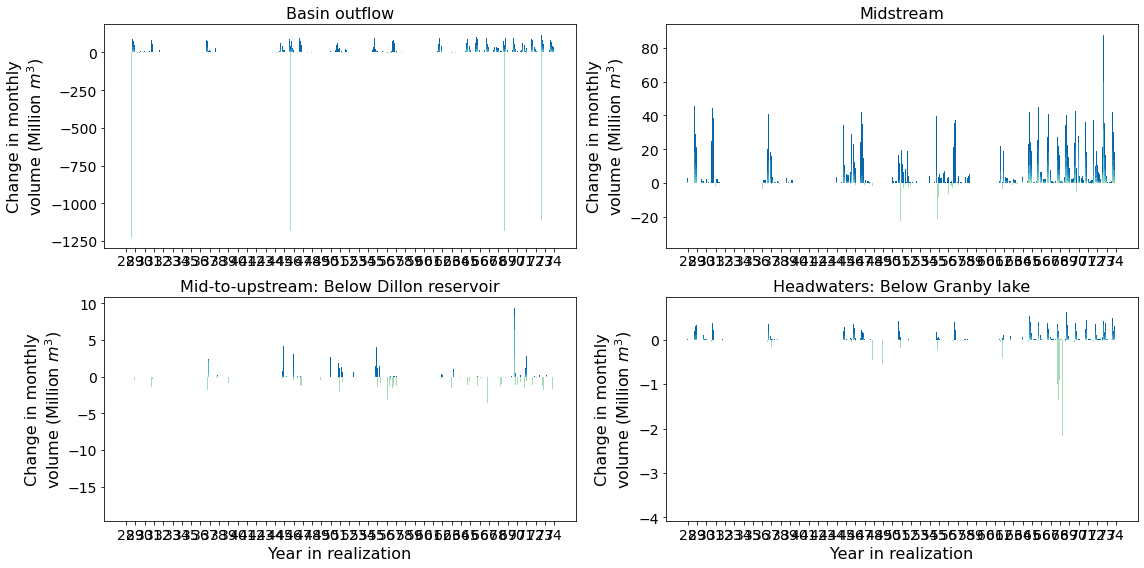

In [25]:
# Locations names
names = ['Basin outflow', 'Midstream', 
         'Mid-to-upstream: Below Dillon reservoir',
         'Headwaters: Below Granby lake']

# Identify mins and maxs across all gauges to set same ylims
min_volume=0
max_volume=0

fig, axs = plt.subplots(2,2, figsize=(16,8))
axs = axs.ravel()
for g in range(len(gauges)):
    ax1 = axs[g]
    # extract changed flows for specific gauge
    changed_flows = np.reshape(df[df['structure_id']==gauges[g]]['river_outflow'].values*1233.4818/1000000, 
                               (int(len(df)/len(structures)/n_files), n_files), order='F')[firstmonth:lastmonth]
    #extract original flows for specific gauge
    original_flows = df_flow[df_flow['structure_id']==gauges[g]]['river_outflow'].values[firstmonth:lastmonth]*1233.4818/1000000
    for i in range(len(p-1)):
        percentile_changes = np.percentile(changed_flows, p[-i], axis=1) - original_flows
        ax1.bar(np.arange(firstmonth, lastmonth), 
                percentile_changes,
                color=colors_to_use[-i])
        if np.max(percentile_changes)> max_volume:
            max_volume=np.max(percentile_changes)
        if np.min(percentile_changes)< min_volume:
            min_volume=np.min(percentile_changes)
    ax1.set_xticks(np.arange(firstmonth, lastmonth, 12))
    
    ax1.set_xticklabels(np.arange(first_year, last_year+1))
    ax1.tick_params(axis='both', labelsize=14)
    ax1.set_ylabel('Change in monthly\nvolume (Million $m^3$)', fontsize=16)
    ax1.set_title(names[g], fontsize=16)
    if g>=2:
        ax1.set_xlabel('Year in realization', fontsize=16)
        
#plt.setp(axs, ylim=[min_volume,max_volume]) 
#plt.setp(axs, yscale='log') 
plt.tight_layout()
#plt.savefig(f'gauge_flow_S{sample}_{realization}.svg')
plt.show()

6

Demand comparison plot

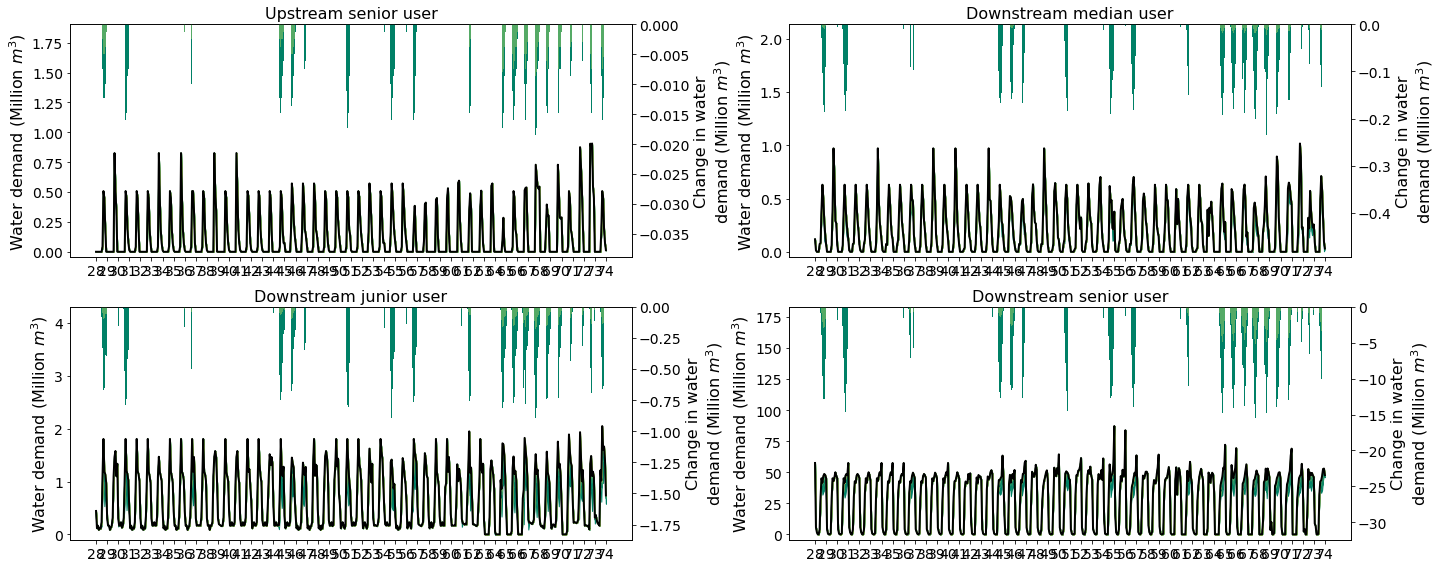

In [26]:
cmap2 = matplotlib.cm.get_cmap('summer')
num_colors=len(p)
colors_to_use_demands = [cmap2(1.*i/num_colors) for i in range(num_colors)]

locations = ['3600687', '7000550', '7200799', '7200645']
names = ['Upstream senior user', 'Downstream median user', 
         'Downstream junior user', 'Downstream senior user']

fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs = axs.ravel()
for g in range(len(locations)):
    ax1 = axs[g]
    ax2 = ax1.twinx()
    # extract changed demands for specific location
    changed_demands = np.reshape(df[df['structure_id']==locations[g]]['demand'].values*1233.4818/1000000, 
                               (int(len(df)/len(structures)/n_files), n_files), order='F')[firstmonth:lastmonth]
    #extract original demand for specific location
    original_demands = df_flow[df_flow['structure_id']==locations[g]]['demand'].values[firstmonth:lastmonth]*1233.4818/1000000
    
    for i in range(len(p)-1):
        ax1.fill_between(np.arange(firstmonth, lastmonth),
                         np.percentile(changed_demands, p[i], axis=1), 
                         np.percentile(changed_demands, p[i+1], axis=1), color=colors_to_use_demands[i])
        ax1.plot(np.arange(firstmonth, lastmonth), 
                 np.percentile(changed_demands, p[i+1], axis=1), color=colors_to_use_demands[i], linewidth=1)
        
        percentile_changes = np.percentile(changed_demands, p[-i], axis=1) - original_demands
        ax2.bar(np.arange(firstmonth, lastmonth), 
                percentile_changes,
                color=colors_to_use_demands[-i])
        
    ax1.plot(np.arange(firstmonth, lastmonth), original_demands, color='black', linewidth=2)
        
    # Create extra space for overlapping graphs
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim(y_min, y_max*2)
    
    y_min, y_max = ax2.get_ylim()
    ax2.set_ylim(y_min*2, y_max)
    
    ax1.set_xticks(np.arange(firstmonth, lastmonth, 12))
    ax1.set_xticklabels(np.arange(first_year, last_year+1))
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14)
    ax1.set_ylabel('Water demand (Million $m^3$)', fontsize=16)
    ax2.set_ylabel('Change in water\ndemand (Million $m^3$)', fontsize=16)
    ax1.set_title(names[g], fontsize=16)
    
#plt.savefig(f'demands_S{sample}_{realization}.svg')
plt.tight_layout()
plt.show()